Importação de Bibliotecas Necessárias

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

Carregamento do Dataset

In [ ]:
data = pd.read_csv('base_tratada.csv')
display(data)

Mesclando colunas [E001] e [VDE001]. Criando nova coluna 'IMC' através das colunas [P00104] e [P00404]

In [ ]:
coluna_e001 = "[E001] Na semana de___ a___ (semana de referência), ___ trabalhou ou estagiou, durante pelo menos uma hora, em alguma atividade remunerada em dinheiro"
coluna_vde001 = "[VDE001] Condição em relação à força de trabalho na semana de referência para pessoas de 14 anos ou mais de idade"
nova_coluna = "Soma_Trabalho_Forca_de_Trabalho"

# Soma os valores das duas colunas
data[nova_coluna] = data[coluna_e001] + data[coluna_vde001]

# Remove as colunas originais (opcional)
data = data.drop(columns=[coluna_e001, coluna_vde001])

peso_col = '[P00104] "Peso - Final (em kg) (3 inteiros e 1 casa decimal)"'
altura_col = '[P00404] "Altura - Final (em cm) (3 inteiros)"'
imc_col = "IMC"

# Calcula o IMC
# Fórmula do IMC: peso (kg) / (altura (m))^2
# A altura está em cm, então precisamos converter para metros dividindo por 100
data[imc_col] = data[peso_col] / ((data[altura_col] / 100) ** 2)

# Remove as colunas de peso e altura originais
data = data.drop(columns=[peso_col, altura_col])
display(data)

Definição da Variável Alvo e das Features

In [149]:
target = "[Q088] Algum médico já lhe deu o diagnóstico de DORT? "
X = data.drop(columns=[target])
y = data[target]

Identificação de Colunas Numéricas e Categóricas

In [150]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

Divisão dos Dados em treino e teste e balanceamento

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Balanceando a base de treino (Undersampling)
print("Proporção da variável alvo ANTES do balanceamento na base de treino:")
print(y_train.value_counts())

# Concatena X_train e y_train para facilitar a separação e o undersampling
train_df = pd.concat([X_train, y_train], axis=1)

# Separa as classes
classe_0 = train_df[train_df[target] == 0]
classe_1 = train_df[train_df[target] == 1]

Settando a proporção de ocorrências de DORT e não-DORT. Nesse caso, número de não-DORT (classe 0) 40% maior

In [ ]:
# Determina o número de amostras para a classe majoritária (você pode ajustar a proporção aqui)
n_samples_classe_1 = len(classe_1)
classe_0_undersampled = classe_0.sample(n=int(n_samples_classe_1 * 1.4), random_state=42)
# classe_0_undersampled = classe_0.sample(n=len(classe_1) * 2, random_state=42)


# Junta as classes balanceadas
train_df_balanced = pd.concat([classe_0_undersampled, classe_1])

# Separa novamente em X_train e y_train balanceados
X_train_balanced = train_df_balanced.drop(columns=[target])
y_train_balanced = train_df_balanced[target]

print("\nProporção da variável alvo APÓS o balanceamento na base de treino:")
print(y_train_balanced.value_counts())

# Identificação de Colunas Numéricas e Categóricas
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

Configuração do Modelo e do Pipeline

In [ ]:
# Solver: SGD; Função de ativação: logistic; Máximo de iterações: 10000
mlp = MLPClassifier(solver='sgd',
                     activation='logistic', 
                     max_iter=10000, 
                     random_state=42, 
                     alpha=0.001) # Evita overfitting

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('clf', mlp)])

param_grid = {
    'clf__hidden_layer_sizes': [
        (5,), (10,), (20,),  # Apenas 1 camada com 5, 10 ou 20 neurônios
        (5, 5), (5, 10), (5, 20),  # 2 camadas: combinações começando com 5 neurônios
        (10, 5), (10, 10), (10, 20),  # 2 camadas: combinações começando com 10 neurônios
        (20, 5), (20, 10), (20, 20)  # 2 camadas: combinações começando com 20 neurônios
    ],
    'clf__learning_rate_init': [0.05, 0.1, 0.2]  # Taxa de aprendizado
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Execução do Grid Search

In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

# Simplesmente extrai os dados relevantes para visualização
results['neurônios'] = results['param_clf__hidden_layer_sizes'].apply(lambda x: x[0])
results['taxa_aprendizado'] = results['param_clf__learning_rate_init']

# Pivot para heatmap (linhas: neurônios, colunas: taxa de aprendizado)
pivot_table = results.pivot_table(
    values='mean_test_score',
    index='neurônios',
    columns='taxa_aprendizado'
)

Visualização dos Resultados do Grid Search

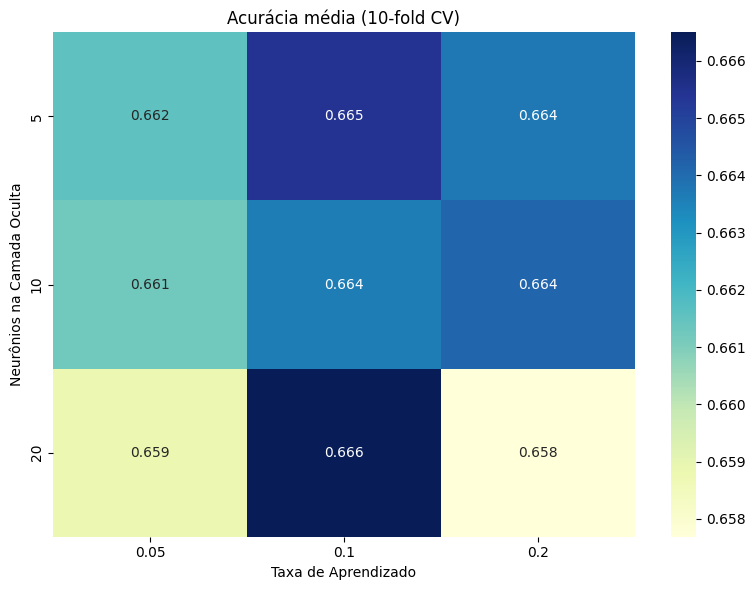

In [ ]:
# Gráfico 1: Heatmap de acurácia
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Acurácia média (10-fold CV)")
plt.xlabel("Taxa de Aprendizado")
plt.ylabel("Neurônios na Camada Oculta")
plt.tight_layout()
plt.show()

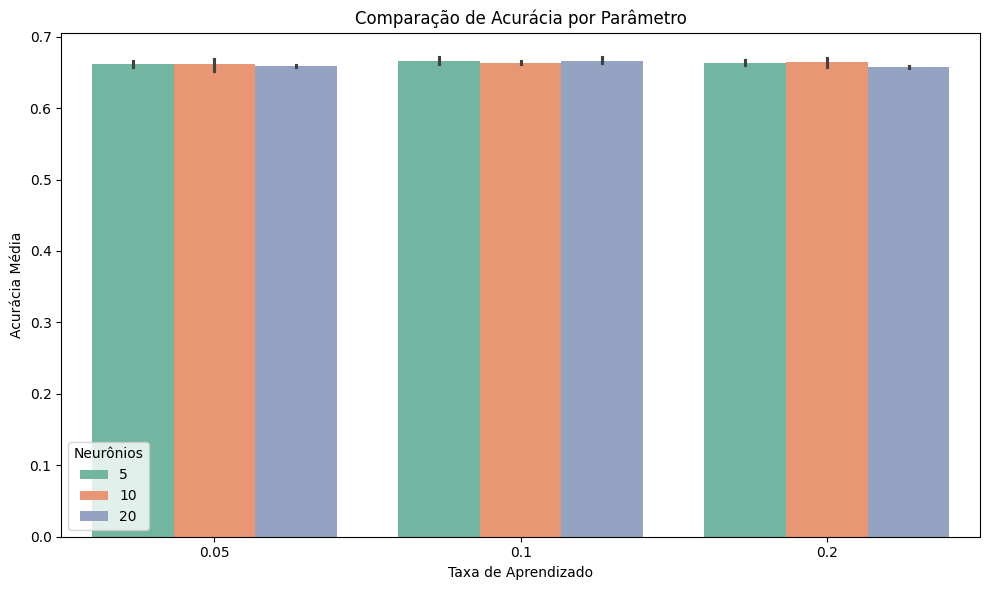

In [ ]:
# Gráfico 2: Barras de desempenho de todas as combinações
plt.figure(figsize=(10, 6))
sns.barplot(
    x='taxa_aprendizado',
    y='mean_test_score',
    hue='neurônios',
    data=results,
    palette="Set2"
)
plt.title("Comparação de Acurácia por Parâmetro")
plt.xlabel("Taxa de Aprendizado")
plt.ylabel("Acurácia Média")
plt.legend(title="Neurônios")
plt.tight_layout()
plt.show()

In [ ]:
# Também imprime o melhor resultado
print("Melhor Parâmetro:", grid_search.best_params_)
print("Melhor Score (Acurácia Média):", grid_search.best_score_)

Melhor Parâmetro: {'clf__hidden_layer_sizes': (20, 10), 'clf__learning_rate_init': 0.1}
Melhor Score (Acurácia Média): 0.674035548913116


Avaliação no Conjunto de Teste


Relatório de Classificação nos Dados de Teste:
              precision    recall  f1-score   support

           0       0.99      0.68      0.81     16277
           1       0.04      0.57      0.07       342

    accuracy                           0.68     16619
   macro avg       0.51      0.63      0.44     16619
weighted avg       0.97      0.68      0.79     16619



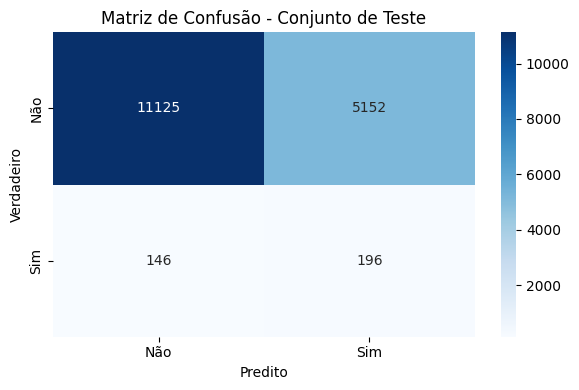

In [ ]:
# Usa o melhor modelo encontrado para prever os dados de teste
y_pred = grid_search.best_estimator_.predict(X_test)

# Relatório de classificação
print("\nRelatório de Classificação nos Dados de Teste:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plot da matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não', 'Sim'], yticklabels=['Não', 'Sim'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Conjunto de Teste')
plt.tight_layout()
plt.show()
